# Machine Learning Poject

In [1]:
import sys
print(sys.executable)

c:\Users\raphp\.conda\envs\ML_env\python.exe


# Project Overview

This project presents an end-to-end workflow on a real-world satellite imagery dataset — from exploratory analysis to predictive modeling and weakly supervised segmentation.

## Task

The main goal of this project is to automatically detect and localize airplanes in satellite images.  
The problem is first approached as a **binary classification task** — determining whether a given 20×20 image tile contains an airplane or not — and later extended to a **segmentation task**, aiming to identify the exact regions where airplanes appear in full satellite scenes.

## Workflow

- **Explore & understand** the dataset structure and class distribution.  
- **Preprocess & clean** the data to make it suitable for analysis.  
- **Build & evaluate** machine learning and deep learning models for classification.  
- **Extend** the approach toward detection and segmentation using CNNs and Grad-CAM methods.  
- **Analyze** the results through quantitative metrics and visual inspection.

## Methodology

We follow a rigorous process, detailing each step from data preparation to model evaluation, explaining why each choice is made, how it is implemented, and what conclusions are drawn at every stage.  
This includes both traditional feature-based methods (SVM, Random Forest) and deep learning architectures (CNN, ResNet).

## Objective

Beyond raw performance, our objective is to develop a **structured and critical analysis** of computer vision techniques applied to satellite imagery,  
highlighting their strengths, limitations, and the challenges of real-world data such as class imbalance and variability in lighting or scale.

## Topic choice

As engineering students in **Industry & Robotics – Aerospace & Defense**, we wanted to work on a subject close to real-world applications and our academic track.  
After working with tabular datasets in previous projects, we decided to focus on **image-based data** to strengthen our understanding of computer vision and machine learning.  
Following extensive research, we selected the **PlanesNet** dataset for its quality, accessibility, and relevance to modern satellite surveillance problems.


# Data Exploration

# Dataset loading and imports

In this part, our goal is to check the **overall health of the dataset** like its structure, number of images, label consistency, and file integrity.  
These checks are essential before starting any kind of manipulation or data exploration.

In [2]:
# CORE IMPORTS
import os
import kagglehub
import glob
import random
import shutil
import zipfile

from pathlib import Path
from PIL import Image
from collections import Counter

# NUMERICS AND DATA HANDLING
import numpy as np
import pandas as pd

# IMAGE PROCESSING
import cv2

# VISUALIZATION
import matplotlib.pyplot as plt

#SKLEARN
from sklearn.model_selection import train_test_split

## Dataset Loading

In this step, we download and explore the **PlanesNet dataset** to check its internal structure and confirm that all files are correctly organized.  
This verification ensures that we can load and use the data properly in the following stages.

In [3]:
from kaggle import api
from pathlib import Path
import shutil

# Create "planesnet" folder next to the notebook (relative path)
path = Path("planesnet")
path.mkdir(exist_ok=True)

# Clean folder content if it already exists
for item in path.iterdir():
    if item.is_file() or item.is_symlink():
        item.unlink()
    elif item.is_dir():
        shutil.rmtree(item)

# Download & unzip the dataset
api.dataset_download_files("rhammell/planesnet", path=str(path), unzip=True)

# Display a few files to confirm
print("Dataset downloaded in:", path.resolve())
print("\nSample files:")
for i, p in enumerate(path.rglob("*")):
    if i > 10: break
    print(" -", p.relative_to(path))


Dataset URL: https://www.kaggle.com/datasets/rhammell/planesnet
Dataset downloaded in: C:\ESILV\A4\Machine_learning\Projet\planesnet

Sample files:
 - planesnet
 - planesnet.json
 - scenes
 - planesnet\planesnet
 - planesnet\planesnet\0__20140723_181317_0905__-122.073653222_37.7090043618.png
 - planesnet\planesnet\0__20140723_181317_0905__-122.083122783_37.7221653245.png
 - planesnet\planesnet\0__20140723_181317_0905__-122.105473207_37.6723685004.png
 - planesnet\planesnet\0__20140723_181317_0905__-122.1075857442429_37.643668625142496.png
 - planesnet\planesnet\0__20140723_181317_0905__-122.14328662_37.697282118.png
 - planesnet\planesnet\0__20140723_181317_0905__-122.166243758_37.6649723192.png
 - planesnet\planesnet\0__20140723_181318_0905__-122.109032733_37.7274203173.png


Once the dataset is downloaded, we inspect its folder structure to confirm the organization of files and subfolders

## Folders architecture

In [4]:
for root, dirs, files in os.walk(path):
    print(root)

planesnet
planesnet\planesnet
planesnet\planesnet\planesnet
planesnet\scenes
planesnet\scenes\scenes


After exploring the main folder, we observed that the dataset contains **two main directories**:
- `planesnet` → Cointain the image tiles used for our classification.  
- `scenes` → includes larger satellite scenes, used later in the project.

To simplify access to the training images, we store their path in a variable.

In [5]:
dataset_images = os.path.join(path, "planesnet\planesnet")#chemin d'acces du dataset

print("\nTrain images dir :", dataset_images)


Train images dir : planesnet\planesnet\planesnet


Next, we verify the number of images inside the dataset to ensure that all files are properly loaded.

In [6]:
images_count = len(os.listdir(dataset_images))

print(f"Nnumber of images in the dataset folder: {images_count} ")

Nnumber of images in the dataset folder: 32000 


We indeed have 32k images in our dataset, but this information is still too vague.  
We now need to take a closer look at how many images belong to each of our two classes.

In [7]:
# 1.1 – Inspection des noms de fichiers 

# Liste les 5 premiers fichiers du dataset
sample_images = sorted(os.listdir(dataset_images))[:5]
print("Nom de fichierdans le data set :")
for name in sample_images:
    print("-", name)


Nom de fichierdans le data set :
- 0__20140723_181317_0905__-122.073653222_37.7090043618.png
- 0__20140723_181317_0905__-122.083122783_37.7221653245.png
- 0__20140723_181317_0905__-122.105473207_37.6723685004.png
- 0__20140723_181317_0905__-122.1075857442429_37.643668625142496.png
- 0__20140723_181317_0905__-122.14328662_37.697282118.png


As mentioned in the dataset description, the image filenames follow a well-defined structure:  

Each individual image filename follows the format:  
`{label}_{scene_id}_{longitude}_{latitude}.png`

- **label** → Takes the value `1` or `0`, representing the *“plane”* and *“no-plane”* classes, respectively.  
- **scene_id** → The unique identifier of the PlanetScope visual scene from which the image was extracted. This ID can be used with the Planet API to locate and download the complete scene.  
- **longitude_latitude** → The geographic coordinates (longitude and latitude) of the image’s center point, separated by a single underscore.


# Quantitative data exploration


## Data balance

Now that the dataset is loaded, we can begin the **exploration phase** by checking the balance between the two classes.  
It is important to verify that one class (for example, “plane”) is not overly represented compared to the other.  
To do this, we extract the first character of each filename, which indicates the label (0 or 1).


In [8]:
image_files = [f for f in os.listdir(dataset_images) if f.endswith('.png')]# liste des nom des 32k d'images
labels = [f[0] for f in image_files]  # on prend juste le premier caractère

nbr0 = labels.count('0')
nbr1 = labels.count('1')

print("Number of non plane images(label 0) =", nbr0, nbr0/images_count*100 , "% -  Number of plane images(label 1) =", nbr1, nbr1/images_count*100,"%")

Number of non plane images(label 0) = 24000 75.0 % -  Number of plane images(label 1) = 8000 25.0 %


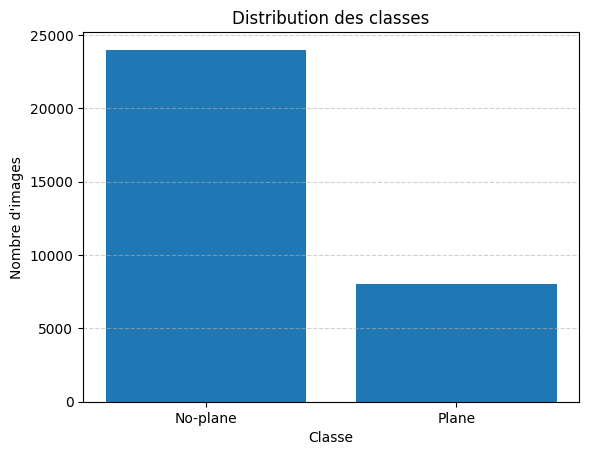

In [9]:
df_counts = pd.DataFrame({
    "Class": ["No-plane", "Plane"],
    "Count": [nbr0, nbr1]  # ou [len(files_0), len(files_1)] selon ton code précédent
})

plt.figure()
plt.bar(df_counts["Class"], df_counts["Count"])
plt.title("Distribution des classes")
plt.xlabel("Classe")
plt.ylabel("Nombre d'images")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

The previous step confirmed that our dataset is imbalanced, with about **three times more non-plane images** than plane images.  
This is an important observation, as it may require applying rebalancing techniques such as **SMOTE** or class weighting during model training.

Before diving into modeling, we can visually inspect a few random samples from both classes to better understand the image content and variability.

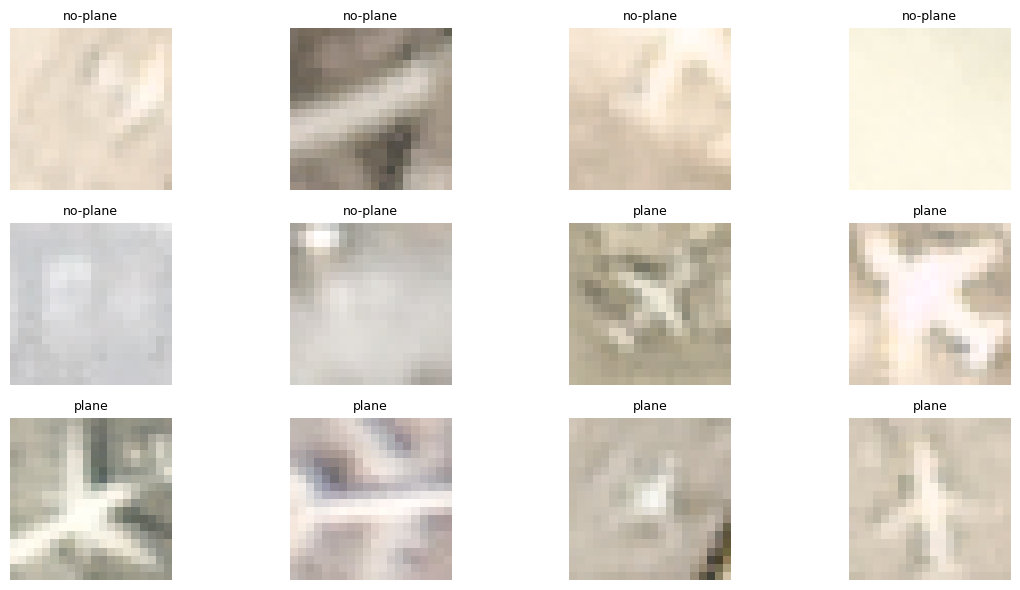

In [10]:

import os, random
import matplotlib.pyplot as plt
from PIL import Image

all_files = [f for f in os.listdir(dataset_images) if f.endswith(".png")]
files_0 = [f for f in all_files if f[0] == "0"]
files_1 = [f for f in all_files if f[0] == "1"]

sample0 = random.sample(files_0, k=min(6, len(files_0)))
sample1 = random.sample(files_1, k=min(6, len(files_1)))
samples = [(f, "no-plane") for f in sample0] + [(f, "plane") for f in sample1]

plt.figure(figsize=(12, 6))
for i, (fname, cls) in enumerate(samples, 1):
    img = Image.open(os.path.join(dataset_images, fname)).convert("RGB")
    plt.subplot(3, 4, i); plt.imshow(img); plt.axis("off"); plt.title(cls, fontsize=9)
plt.tight_layout(); plt.show()


Here’s a preview of our dataset: small image tiles that either capture **aircraft** or **ground** surfaces.  
These samples help us get an initial sense of what the model will learn to distinguish.

## Aspect ration and sharpness 

Now that we have visualized the dataset, we can analyze some image-level characteristics such as their **aspect ratio** and **sharpness**.

- The **aspect ratio** is defined as the width-to-height ratio of an image.  
  It helps confirm that all tiles have consistent dimensions.  
- The **sharpness** is estimated using the `Laplacian variance`, a mathematical measure of pixel intensity changes —  
  higher variance indicates sharper images, while lower variance suggests blur.

Disclamer : this methods is quite long because it compute on each images comparing pixels intensity so it will take time

In [11]:
def compute_metrics(files, base_dir):
    ratios, sharp = [], []
    for fname in files:
        path = os.path.join(base_dir, fname)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  #grayscale
        h, w = img.shape[:2]
        ratios.append(w / h)
        sharp.append(cv2.Laplacian(img, cv2.CV_64F).var())
    return np.array(ratios), np.array(sharp)

ratios_0, sharp_0 = compute_metrics(files_0, dataset_images)
ratios_1, sharp_1 = compute_metrics(files_1, dataset_images)

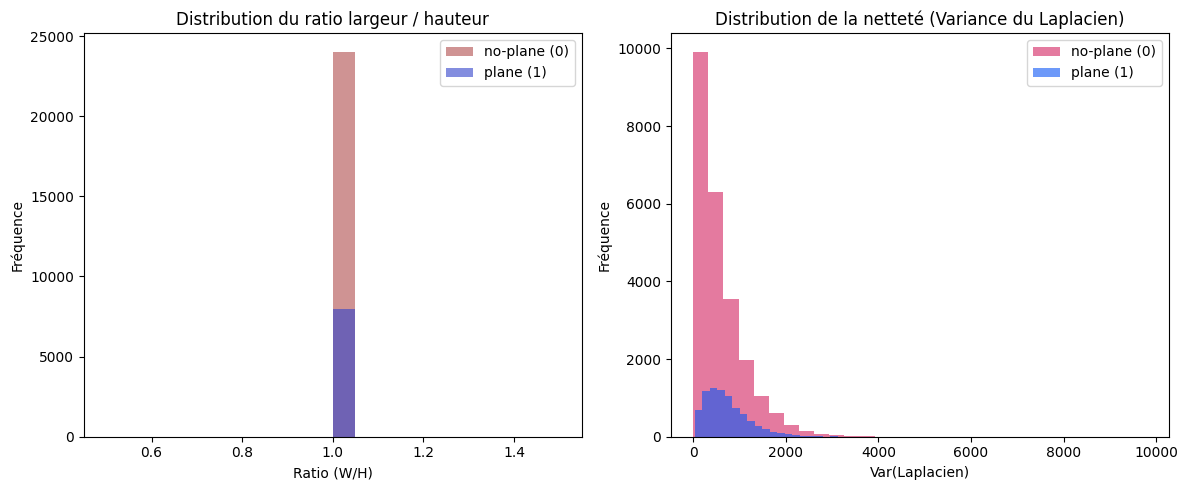

Netteté moyenne no-plane : 570.06
Netteté moyenne plane    : 727.45


In [12]:
plt.figure(figsize=(12,5))

# 1 Histogramme du ratio W/H
plt.subplot(1,2,1)
plt.hist(ratios_0, bins=20, alpha=0.6, label='no-plane (0)', color="#B04C4C")
plt.hist(ratios_1, bins=20, alpha=0.6, label='plane (1)', color="#3042CB")
plt.title('Distribution du ratio largeur / hauteur')
plt.xlabel('Ratio (W/H)')
plt.ylabel('Fréquence')
plt.legend()

# 2️ Histogramme de la netteté (Variance du Laplacien)
plt.subplot(1,2,2)
plt.hist(sharp_0, bins=30, alpha=0.6, label='no-plane (0)', color="#D22260")
plt.hist(sharp_1, bins=30, alpha=0.6, label='plane (1)', color="#0C56F5")
plt.title('Distribution de la netteté (Variance du Laplacien)')
plt.xlabel('Var(Laplacien)')
plt.ylabel('Fréquence')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Netteté moyenne no-plane : {np.mean(sharp_0):.2f}")
print(f"Netteté moyenne plane    : {np.mean(sharp_1):.2f}")

### Image Size and Sharpness Analysis  

The first graph shows that all images share the same aspect ratio and identical dimensions.  
This means there’s no need for cropping during preprocessing.  
However, this doesn’t necessarily exclude the need for resizing, depending on the model’s input requirements.


### Sharpness Distribution  

When analyzing sharpness, we observe that both classes have a similar distribution, roughly ranging from 0 to 3000, with a peak around 500.  
It’s important not to be misled by the wider distribution of the no-plane class — this simply reflects the fact that there are more samples in that category.  
Still, the average sharpness suggests that images containing aircraft tend to be slightly sharper (570 vs. 727).

## Pixel Intensity Histogram  

Next, we examine the histogram of pixel intensity levels**, based on grayscale images.  
This helps us measure image contrast:  

- A low-intensity distribution (close to 0) indicates underexposed or darker images.  
- A high-intensity distribution (close to 255) indicates overexposed or brighter images.  
- A well-contrasted** image typically uses the entire range from 0 to 255.  

To get an overall view, we’ll sum all individual histograms for each label to obtain a global histogram per class.

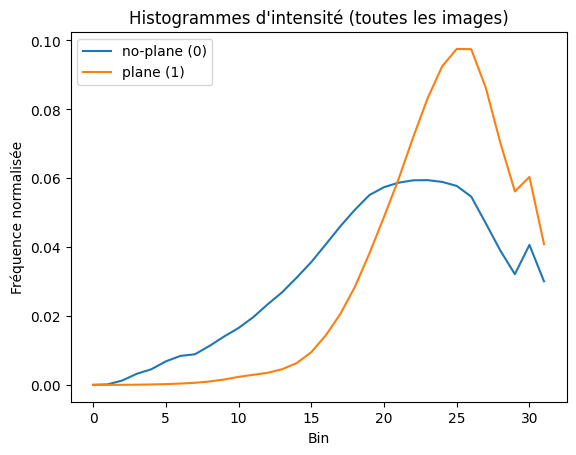

In [13]:
def gray_hist_all(files, base_dir, bins=32):
    hist = np.zeros(bins, dtype=np.int64)
    for fname in files:
        img = cv2.imread(os.path.join(base_dir, fname), cv2.IMREAD_GRAYSCALE)
        h, _ = np.histogram(img, bins=bins, range=(0, 256))
        hist += h
    s = hist.sum()
    return (hist / s) if s else hist

bins = 32
h0 = gray_hist_all(files_0, dataset_images, bins=bins)
h1 = gray_hist_all(files_1, dataset_images, bins=bins)
x  = np.arange(bins)

plt.figure()
plt.plot(x, h0, label="no-plane (0)")
plt.plot(x, h1, label="plane (1)")
plt.title("Histogrammes d'intensité (toutes les images)")
plt.xlabel("Bin"); plt.ylabel("Fréquence normalisée"); plt.legend(); plt.show()

### Interpreting the Histogram  

To avoid differences caused by class imbalance (as seen in previous graphs), we normalized the frequencies.  
On the X-axis, we have the 32 subcategories (*bins*) into which pixel values are grouped.  

Overall, both curves rise and reach a maximum between bins 20 and 25, indicating that the images tend to be fairly bright, with many light-colored pixels.  


### Comparing the Two Curves  

Looking at each curve individually, a few distinctions appear:  
- The blue curve (non-plane images) peaks around bin = 21 and shows a gradual, almost linear increase up to that point.  
- The orange curve (plane images) has *fewer values* between bins 5 and 15, but a sharper, higher peak around bin = 24.  

This suggests that images containing aircraft (label = 1) are on average brighter than those labeled 0 (no-plane).

---


# Preprocessing

### Train/Validation/Test Split

We first split our data into train and validation sets.  
- The train set (70% of the data) is used to fit the model and will undergo **data augmentation**.  
- The validation set contains training-like images used to **tune hyperparameters**.  (15% of the data)
- The test set remains **completely unseen** during training and validation, and is used for the final evaluation. (15% of the data)


**Preserving Class Balance (Stratification)**

As noted earlier, we must keep the **same label ratio** across the splits.  
To ensure this, we perform a stratified split (using the `stratify` parameter),like we see it during classes. It preserves the class distribution in train, validation, and test sets.


In [14]:
X = image_files
y = [int(f[0]) for f in image_files]  # label 0 ou 1

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

#X_temp represent the temporary split 30% that help us to make the Valid and Test split with 15% each

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

X sets are so a liste of images names and y are only intefer of 1 or 0 the class we had to put the image in

### Step 1 — Image Denoising (Median Filter)

We now denoise the images to avoid contaminating feature extraction steps that are sensitive to noise (e.g., HOG or LBP).  
We use a median filter, which effectively removes impulsive noise while preserving edges that the Gaussian one does not kept to the same extent.

This helps maintain **sharp boundaries and contours**, improving the quality of downstream handcrafted features.


In [15]:
def apply_median_denoise(img_gray):
    #Input : grayscale image
    #Output : denoised grayscale image

    ksize = 3 #kernel size 
    img_denoised = cv2.medianBlur(img_gray, ksize)
    
    return img_denoised

In [16]:
#Sanity check for only three images of X train.

sample_files = X_train[:3]
for filename in sample_files:
    filepath = os.path.join(dataset_images, filename)
    
    img_bgr = cv2.imread(filepath)
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY) #convert to grayscale
    img_denoised = apply_median_denoise(img_gray) # apply denoise function

print("Denoise test OK")

Denoise test OK


### Step 2 — Histogram Equalization and Contrast Normalization 


Next, we apply histogram equalization and contrast normalization to improve the overall pixel distribution.  
The goal is to **spread pixel intensities** more evenly across their full range (0–255), enhancing the **visual contrast** without significantly altering image content.  

We use the `CLAHE` (Contrast Limited Adaptive Histogram Equalization) technique, which operates on local regions rather than the entire image at once.  
This localized approach provides better contrast enhancement while avoiding over-amplification of noise or brightness in uniform areas.


In [17]:
def apply_clahe(img_gray):
    # parameters size of tile (4,4) and clip=2.0 
    # 
    # clipLimit is the threshold for contrast limiting
    # tilesize grid is used to divide the image into grid
    
    clahe_tool = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
    
    img_clahe = clahe_tool.apply(img_gray)
    
    return img_clahe

In [18]:
#Sanity check for only three images of X train.

sample_files = X_train[:3]
for filename in sample_files:
    filepath = os.path.join(dataset_images, filename)
    

    img_bgr = cv2.imread(filepath)
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY) # convert to grayscale
    img_clahe_final = apply_clahe(img_denoised) # apply CLAHE function

print("CALHE test OK")

CALHE test OK


### Step 3 — Pixel Standardization  


The first preprocessing step is **pixel standardization**.  
We subtract the **mean pixel value** (computed over all training images) and divide by their **standard deviation**.  

This ensures that all pixel values are on a **comparable scale**, improving **model stability** and **training convergence**. 

However there is a big **WARNING** here because we are gonna use a mean and a standard devaition we must need two compute it only with the images of X_train. Meaning that we will use the mean and std of X_train on the X_valid, X_test split. If we dont do that and compute the std and mean of the 32k images, we let X_train see infos of others  partitions that is not supossed to know. This is called data leakage and it's completly forebidden in Machine Learning because it will compromise the reliability of findings.


In [19]:
def compute_dataset_mean_std(file_list, base_dir, sample_max=None):    
    files = random.sample(file_list, min(sample_max, len(file_list))) if sample_max else file_list
    
    s = 0.0 #sum
    ss = 0.0 #sum of square
    n = 0 # pixels numbers
    
    for fname in files:
        filepath = os.path.join(base_dir, fname)
        
        img_gray = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE) #load images in grayscale
            
        pixels_float = img_gray.astype(np.float32) / 255.0 #convert pixels into normalize float
        
        #updates sums
        s += pixels_float.sum() 
        ss += (pixels_float ** 2).sum()
        n += pixels_float.size # .size gives total numbers of pixel
    
    if n == 0:
        return 0.0, 0.0 # to avoid division by zero

    #compute mean and std 4. Calculer la moyenne et l'écart-type
    mean = s / n
    std = np.sqrt(ss / n - mean ** 2)
    
    return mean, std

In [20]:
#Sanity check for only three images of X train.

mean_security, std_security = compute_dataset_mean_std(X_train[:3], dataset_images, sample_max=None)

print("Mean train (RGB):", mean_security)
print("Std  train (RGB):", std_security)

Mean train (RGB): 0.8226961
Std  train (RGB): 0.11227682


### Step 4 — Data Augmentation


**Goal:** increase visual variability in the training set to make learning more robust and reduce overfitting.

We will apply light, label-preserving transforms such as:
- **Rotations** (small angles)  
- **Horizontal/vertical flips**  
- **Brightness/contrast tweaks**  
- **Additive noise** (Gaussian)  
- **Blur**  
- **Shifts/Zooms** 

These augmentations create realistic variations while keeping the underlying class unchanged.


In [21]:
# Data images augmentation parameters
N_AUG_PER_IMAGE = 1  # number of modifications
RANDOM_SEED = 1337

In [22]:
def augment_opencv(img):
    """Applique des augmentations aléatoires à une image uint8."""
    
    # Horizontal flip (p=0.5)
    if np.random.rand() < 0.5:
        img = cv2.flip(img, 1)

    # Rotation [-10°, 10°] (p=0.5)
    if np.random.rand() < 0.5:
        h, w = img.shape[:2]
        angle = np.random.uniform(-10, 10)
        M = cv2.getRotationMatrix2D((w * 0.5, h * 0.5), angle, 1.0)
        img = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT101)

    # Brightness/Contrast (p=0.8)
    if np.random.rand() < 0.8:
        alpha = np.random.uniform(0.8, 1.2)  # contraste
        beta = np.random.uniform(-20, 20)     # luminosité (float plus cohérent)
        img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

    # Gaussian Blur (p=0.3)
    if np.random.rand() < 0.3:
        k = np.random.choice([3, 5])
        img = cv2.GaussianBlur(img, (k, k), 0)

    # Gaussian Noise (p=0.3)
    if np.random.rand() < 0.3:
        sigma = np.random.uniform(3, 8)
        noise = np.random.normal(0, sigma, img.shape)
        img = np.clip(img + noise, 0, 255).astype(np.uint8)  # optimisé

    return img

In [23]:
# Ta fonction 'augment_and_save' (corrigée pour être plus claire)
def augment_and_save(file_list, in_dir, out_dir, n_aug=1):
    os.makedirs(out_dir, exist_ok=True)
    
    for fname in file_list:
        path = os.path.join(in_dir, fname)
        img  = cv2.imread(path, cv2.IMREAD_COLOR)
        if img is None: 
            continue
            
        # 1. Sauvegarde l'image ORIGINALE dans le nouveau dossier
        cv2.imwrite(os.path.join(out_dir, fname), img)

        # 2. Sauvegarde les versions AUGMENTÉES dans le nouveau dossier
        stem, ext = os.path.splitext(fname)
        for i in range(n_aug):
            aug = augment_opencv(img)
            cv2.imwrite(os.path.join(out_dir, f"{stem}_aug{i}{ext}"), aug)



In [24]:
augmented_images_directory = os.path.join(path, "planesnet_augmented_train")

print(f"Génération du set d'entraînement augmenté dans : { augmented_images_directory}")
augment_and_save(X_train, dataset_images,  augmented_images_directory, n_aug=N_AUG_PER_IMAGE)

files_in_augmented_dir = glob.glob(os.path.join( augmented_images_directory, "*.png"))
print(f"Le dossier {augmented_images_directory} contient maintenant : {len(files_in_augmented_dir)} images")

Génération du set d'entraînement augmenté dans : planesnet\planesnet_augmented_train
Le dossier planesnet\planesnet_augmented_train contient maintenant : 44800 images


We now put the name of those images in an array like X_test et X_valide named 'X_train_augmented'  

In [25]:

X_train_augmented = [f for f in os.listdir(augmented_images_directory) if f.endswith(".png")]
print(f"Liste 'X_train_augmented' (noms de fichiers) créée. Total : {len(X_train_augmented)} images.")

y_train_augmented = [int(fname[0]) for fname in X_train_augmented] #meme methode que pour la creation de y
print(f"Liste 'y_train_augmented' (labels) créée. Total : {len(y_train_augmented)} étiquettes.")


Liste 'X_train_augmented' (noms de fichiers) créée. Total : 44800 images.
Liste 'y_train_augmented' (labels) créée. Total : 44800 étiquettes.


We are know going to apply the preprocessing to the three set X_train_augmented, X_test, X_valid because we need comparable images. We first need to compute the mean and std function for the normalisation on X_train because its the only knowed set.

However, we are not going to apply denoise function in the pipeline because or goal is to make our model robust and that's why we add noise in our images in the augmentation. Applying a denoising on them will be counter productive and give poor training images.

In [26]:
mean_X_train, std_X_train = compute_dataset_mean_std(X_train, dataset_images, sample_max=None)

print("Mean train (RGB):", mean_X_train)
print("Std  train (RGB):", std_X_train)

Mean train (RGB): 0.6875121
Std  train (RGB): 0.19024603


In [27]:
from tqdm.notebook import tqdm # Pour les barres de progression

def pipeline_grayscale_preprocessing(filename_list, base_dir,mean_val=mean_X_train, std_val=std_X_train):
   
    processed_images = [] #stock procceed images
    
    for filename in tqdm(filename_list, desc=f"Processing {len(filename_list)} images"): #tqdm is to but a loading vizualisation
        
        filepath = os.path.join(base_dir, filename)

        img_bgr = cv2.imread(filepath) #load image
        img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY) # convert in grayscale
        img_clahe = apply_clahe(img_gray) #apply clahe
        img_float = img_clahe.astype(np.float32) / 255.0 #convert pixels in float
        img_standardized = (img_float - mean_val) / std_val # standardize
        processed_images.append(img_standardized) # add to the list
        
    return np.array(processed_images)

In [28]:
# applying pipeline on all the three X sets
X_train_processed = pipeline_grayscale_preprocessing( X_train_augmented, augmented_images_directory)
X_valid_processed = pipeline_grayscale_preprocessing( X_valid, dataset_images)
X_test_processed = pipeline_grayscale_preprocessing( X_test, dataset_images)

Processing 44800 images:   0%|          | 0/44800 [00:00<?, ?it/s]

Processing 4800 images:   0%|          | 0/4800 [00:00<?, ?it/s]

Processing 4800 images:   0%|          | 0/4800 [00:00<?, ?it/s]

## Formalisation of the Problem[¶](#Formalisation-of-the-Problem)

### Objective

The purpose of this project is to build a model that can automatically tell whether a small satellite image contains an **airplane** or **not**. In other words, we want to classify each image into one of two categories: *airplane* or *no-airplane*.

### Problem Definition

Each image in the dataset is a 20×20 RGB tile taken from satellite imagery.

* **Input (X):** a 20×20×3 image (with 3 color channels: red, green, blue)
* **Output (Y):**

$$
Y =
\begin{cases}
1, & \text{if the image contains an airplane} \\
0, & \text{if it does not contain an airplane}
\end{cases}
$$This is a **supervised classification** problem: every image is already labeled, and our model must learn a function

$$
f: X \rightarrow Y
$$that predicts the correct label for new, unseen images.  

The model is trained to minimize a **binary cross-entropy loss**:

$$
\hat{f} = \arg\min\_f \frac{1}{N} \sum\_{i=1}^{N} \mathcal{L}(f(X\_i), Y\_i)
$$

### Dataset Description

The **PlanesNet** dataset contains tens of thousands of small 20×20 color satellite tiles. Each tile is annotated as either containing an airplane or not.

| Attribute | Description |
| --- | --- |
| Image size | 20×20 pixels |
| Channels | RGB (3) |
| Labels | Binary (airplane / no-airplane) |
| Type | Supervised classification |

This makes it a great dataset for experimenting with small-scale computer vision models.

### Learning Approach

The task will be approached as a **binary image classification** problem. We can use:

* **Convolutional Neural Networks (CNNs)** for end-to-end feature extraction and classification, or
* **Traditional ML models** (like SVM or Random Forest) using handcrafted features.

The goal is to learn a model that can generalize well and correctly identify airplanes in new satellite images.

### Evaluation Metrics

To evaluate performance, we’ll use several metrics derived from the **confusion matrix**:

* **True Positives (TP):** airplane correctly detected
* **True Negatives (TN):** no-airplane correctly identified
* **False Positives (FP):** no-airplane incorrectly marked as airplane
* **False Negatives (FN):** airplane missed by the model

From these values, we can calculate:

* **Accuracy:** overall proportion of correct predictions
* **Precision:** proportion of correct airplane detections among all airplane predictions
* **Recall (Sensitivity):** proportion of actual airplanes correctly detected
* **F1-score:** balance between precision and recall

Accuracy is defined as:

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

### Challenges

Working with this dataset comes with a few difficulties:

* Images are very small (20×20), which limits the amount of visual information available.
* Airplanes appear at different scales, orientations, and lighting conditions.
* The background (airports, cities, deserts, etc.) can vary a lot, making detection harder.

### Expected Outcome

At the end of the project, we expect to obtain a model capable of automatically detecting airplanes in unseen satellite images.  

Such a system could be useful for applications like airport monitoring, aerial mapping, or defense and logistics planning.
g applications such as aerial monitoring, airport mapping, or infrastructure analysis.

---

# Features Extraction

This step is the most important step in computer vision. Because classical learning models like svm or decision tree cannot see images we had to describe it for them. To do that we will use some algorithms that take image in input and give back vectors that discribe or image. The most famous of the is HOG for Histogram of Oriented Gradient. Because HOG methdods can output very long vectors, we are fisrt use only this methods and then we will extend our pipeline with other methods.

In HOG method we found those steps : 
 - Grayscale convertion
 - Sobel gradient for edge detection
 - Image division in cells (cellSize parameter)
 - Histogramm direction of each cells (return 9 orientations by default, nbins parameter)
 - Regroup cells into blocks (blockSize parameter)
 - Normalisation of pixels intensity by blocks 

Because we have image size of 20x20, if we chose a cellSize of 4x4 and a blockSize of 2x2 meaning 4 cells per block we will have : "4*4*9*4 = 576" an vector containing 576 features. 

### HOG implementation

In [29]:
from skimage.feature import hog

def extract_hog_features(img_gray_processed, pixelsPerCell=4, cellsPerBlock=2, orientations=9):
    
    hog_vector = hog(
        img_gray_processed, 
        orientations=orientations, 
        pixels_per_cell=(pixelsPerCell, pixelsPerCell),
        cells_per_block=(cellsPerBlock, cellsPerBlock),
        block_norm='L2-Hys',  # 'L2-Hys' is the standard normalisation method
        visualize=False,
        feature_vector=True  # allow to get a 1D vector
    )
    
    return hog_vector

In [30]:
def create_hog_dataset(image_list):

    hog_features_list = []
    
    for img in tqdm(image_list, desc="Extraction HOG"):
        hog_vector = extract_hog_features(img)
        hog_features_list.append(hog_vector)
        
    
    return np.array(hog_features_list) #we convert the list in a numpy array before returning it

In [31]:
print("HOG extraction")
X_train_hog = create_hog_dataset(X_train_processed)
X_valid_hog = create_hog_dataset(X_valid_processed)
X_test_hog  = create_hog_dataset(X_test_processed)

print("Results : ")
print(f"Shape X_train_hog : {X_train_hog.shape}")
print(f"Shape X_valid_hog : {X_valid_hog.shape}")
print(f"Shape X_test_hog  : {X_test_hog.shape}")


#sanity check visualisation by adding y column at the end
df_train_hog = pd.DataFrame(X_train_hog)
df_train_hog['label'] = y_train_augmented

df_valid_hog = pd.DataFrame(X_valid_hog)
df_valid_hog['label'] = y_valid

print(f"\nHOG Dataframe  :")
print(df_train_hog.head())

HOG extraction


Extraction HOG:   0%|          | 0/44800 [00:00<?, ?it/s]

Extraction HOG:   0%|          | 0/4800 [00:00<?, ?it/s]

Extraction HOG:   0%|          | 0/4800 [00:00<?, ?it/s]

Results : 
Shape X_train_hog : (44800, 576)
Shape X_valid_hog : (4800, 576)
Shape X_test_hog  : (4800, 576)

HOG Dataframe  :
          0         1         2         3         4         5         6  \
0  0.271146  0.179240  0.256760  0.000000  0.271146  0.000000  0.048553   
1  0.274512  0.044683  0.000000  0.000000  0.274512  0.173631  0.199880   
2  0.212041  0.000000  0.000000  0.138595  0.147658  0.258671  0.125467   
3  0.090802  0.067526  0.000000  0.000000  0.258217  0.258217  0.252301   
4  0.256196  0.000000  0.256196  0.256196  0.256196  0.000000  0.002106   

          7         8         9  ...       567       568       569       570  \
0  0.000000  0.156223  0.271146  ...  0.247213  0.065337  0.220100  0.054259   
1  0.000000  0.048282  0.274512  ...  0.247263  0.045828  0.052091  0.076280   
2  0.109098  0.000000  0.258671  ...  0.158802  0.075028  0.119788  0.000000   
3  0.101662  0.000000  0.258217  ...  0.266505  0.244126  0.000000  0.000000   
4  0.000000  0.000000  

In [32]:
print("la taille de notre data frame est donc de :",X_train_hog.shape)

la taille de notre data frame est donc de : (44800, 576)


We have here a dataframe of 44800 rows and 576 columns with numerical values exactly like a csv dataset or something else. We can know apply classic machine learning preocedure. For intance we have, imbalance between our classes and too much features to train a model now.

There are two solutions for the problems we are face of. To correct imbalance we are going to apply SMOTE and for the oversize features numbers we will apply a PCA 

#### The question is which one we apply first ?

There is actually no good answer to this question, after searching on multiple sources, website, forums ect we cannot find one unique opinion. Let's try to answer it our self. We are face of two common problems in machine learning, we indeed have a big dimensionnality in our data, 576 columns, we cannot train a model on such amount of features it will result poor learning and confusion in wheigts attributed to each feature because they are to numerous to be handled. The second problem is also common, classes are imbalanced we have more 0 than 1 in our data set, we kept this ratio constant all over he preprocessing by specify "statify=y" during splits. 

- To correct the execessive number of features and reduce it we are going to apply a Principal Component Analysis or PCA by analysis variance and covariance and compute eigenvectors it will select the most important features that the model will be train on.

- To handle class imbalanced the common way to do it is to artificially create values of the minoritary class. For that we are going to use SMOTE algorithm

When understanding how both algorithm works we are now capable to answer our dilemma. Because PCA purpose is to reduce numbers of features and rely on variance using it with real data from our dataset and artificial datas from SMOTE will change variances and covariances in the set and disturb how they are naturally spread. So, in our mind it is better to proceed to the PCA firt and then to the imbalance correction.


When using PCA function we need to specify how many output component we actually want but this is not a simple question to answer. Reducing features from 576 to 3 for example automaticaly lead to a huge loss of information and passing from 576 to 500 is neither better because we still have to much features for the model. To select a good number of component we are going to plot the ratio of explained variance, this tool will help us to evaluate how importante a feature is.

To find the best number of component we are going to plot the sum of explained variance over number of features. For that, we are going to lauch a pca but on all the 576 features and then compute the explained variance. On the plot we will also put a line at 95% of explained variance and find on the x axis the number of features. 

Train PCA on X_train_hog
PCA done


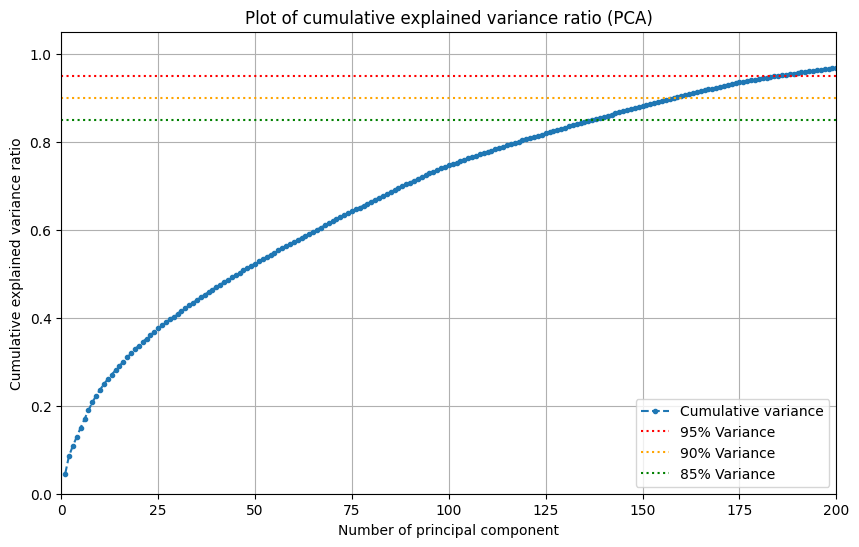

In [33]:
from sklearn.decomposition import PCA

pca = PCA()#create PCA

print("Train PCA on X_train_hog")
pca.fit(X_train_hog)
print("PCA done")

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)


plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='.', linestyle='--', label='Cumulative variance')

#reference line
plt.axhline(y=0.95, color='red', linestyle=':', label='95% Variance')
plt.axhline(y=0.90, color='orange', linestyle=':', label='90% Variance')
plt.axhline(y=0.85, color='green', linestyle=':', label='85% Variance')

plt.title('Plot of cumulative explained variance ratio (PCA)')
plt.xlabel('Number of principal component')
plt.ylabel('Cumulative explained variance ratio')
plt.legend(loc='best')
plt.grid(True)
plt.ylim(0, 1.05) # limit y axis form O to 105%
plt.xlim(0, 200) # limit for the 200 first features 

plt.show()

The plot contain very precious informations, visualy we see that we approximatly only need to keep 190 features to explain 95% of the variance. Great news we found our principals composantes number = 190. But again becareful we need to fit the PCA only with X_train_hog otherwise we will face to data leakage.

In [34]:
N_COMPONENTS=190
pca = PCA(n_components=N_COMPONENTS, random_state=42)

print(f"PCA training on {N_COMPONENTS} component")
X_train_pca = pca.fit_transform(X_train_hog)#fit on X_train_hog

print("Applying PCA on X_valid_hog and X_test_hog")
X_valid_pca = pca.transform(X_valid_hog)#apply on both train_hog and test_hog
X_test_pca = pca.transform(X_test_hog)

print("Results")
total_variance_captured = np.sum(pca.explained_variance_ratio_)
print(f"Total Variance Captured by {N_COMPONENTS} components : {total_variance_captured * 100:.2f}%")
print(f"Shape de X_train_pca : {X_train_pca.shape}")
print(f"Shape de X_valid_pca : {X_valid_pca.shape}")
print(f"Shape de X_test_pca : {X_test_pca.shape}")

PCA training on 190 component
Applying PCA on X_valid_hog and X_test_hog
Results
Total Variance Captured by 190 components : 95.61%
Shape de X_train_pca : (44800, 190)
Shape de X_valid_pca : (4800, 190)
Shape de X_test_pca : (4800, 190)


The PCA function well. We can now apply SMOTE but only on X_train. Why ? Because X_valid is mean to represent the reality and is here to correct hyper parameters later on so we need to keep it close to the reality and not modify his balance. 

In [38]:
from imblearn.over_sampling import SMOTE
from collections import Counter # usefull to verify

counter_before = Counter(y_train_augmented)
print(f"Class distribution before SMOTE : {counter_before}")

smote = SMOTE(random_state=42) #smote execution
X_train_smote, y_train_smote = smote.fit_resample(X_train_pca, y_train_augmented)

counter_after = Counter(y_train_smote)
print(f"Class distribution after SMOTE : {counter_after}")

print(f"\nShape dofe X_train (before SMOTE) : {X_train_pca.shape}")
print(f"Shape of X_train (after SMOTE) : {X_train_smote.shape}")
print(f"Length of y_train (after SMOTE) : {len(y_train_smote)}")

Class distribution before SMOTE : Counter({0: 33600, 1: 11200})
Class distribution after SMOTE : Counter({0: 33600, 1: 33600})

Shape dofe X_train (before SMOTE) : (44800, 190)
Shape of X_train (after SMOTE) : (67200, 190)
Length of y_train (after SMOTE) : 67200
